<a href="https://colab.research.google.com/github/NitCoh/TextAnalysisForBigData/blob/master/Big_Data_Analysis_for_Cyber_Security_Text_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# **Initial Data Exploration**

DATA_COLS:
Columns:
FileNameID,Sha256ID,Md5ID,Sha1ID,IssuerID,SignerID,PublisherID,WebFileIpID,WebFileUrlID,ThreatFamilyID,ThreatNameID,SigSeqID,SignatureNameID,MachineGuidID,RowNumber,PeAttributesString,WebFileUrlDomain,WebFileUrlHostname,Ctph,LsHash,ThreatCategory,ReportTime,SpynetReportGuid,Firewall,Size,Version,Type,SignerHash,IssuerHash,IsValidCertificate,CertInvalidDetails,Checksum,IsRuntimePacked,FileAccess,Screensaver,StartupUserFolder,MarkOfTheWeb,UsnTimestamp,IsInContainer,IsContainer,IsPEFile,IsAutoRunInf,PeTimestamp

Upload the data file!

In [185]:
COLS = "FileNameID,Sha256ID,Md5ID,Sha1ID,IssuerID,SignerID,PublisherID,WebFileIpID,WebFileUrlID,ThreatFamilyID,ThreatNameID,SigSeqID,SignatureNameID,MachineGuidID,RowNumber,PeAttributesString,WebFileUrlDomain,WebFileUrlHostname,Ctph,LsHash,ThreatCategory,ReportTime,SpynetReportGuid,Firewall,Size,Version,Type,SignerHash,IssuerHash,IsValidCertificate,CertInvalidDetails,Checksum,IsRuntimePacked,FileAccess,Screensaver,StartupUserFolder,MarkOfTheWeb,UsnTimestamp,IsInContainer,IsContainer,IsPEFile,IsAutoRunInf,PeTimestamp"
cols_names = COLS.split(",")
cols_names
len(cols_names)

43

In [186]:
## Upload the data file first!
data_path = '/content/Obf_oneInTenWeek1_d1.tsv'

df = pd.read_csv(data_path,sep='\t', names=cols_names)
df.tail(n=6)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,FileNameID,Sha256ID,Md5ID,Sha1ID,IssuerID,SignerID,PublisherID,WebFileIpID,WebFileUrlID,ThreatFamilyID,ThreatNameID,SigSeqID,SignatureNameID,MachineGuidID,RowNumber,PeAttributesString,WebFileUrlDomain,WebFileUrlHostname,Ctph,LsHash,ThreatCategory,ReportTime,SpynetReportGuid,Firewall,Size,Version,Type,SignerHash,IssuerHash,IsValidCertificate,CertInvalidDetails,Checksum,IsRuntimePacked,FileAccess,Screensaver,StartupUserFolder,MarkOfTheWeb,UsnTimestamp,IsInContainer,IsContainer,IsPEFile,IsAutoRunInf,PeTimestamp
205785,7689177,11832730,12791649,14255608,9641,46623,188146,461585,5397947,2720,5644,1036641,221,11713297,9208600,NaN,mediafire.com,download1662.mediafire.com,3072:tf6yptEYKRitLMGYeAyqsR2yE0zx9cXXYuCtylx9e...,9dd7bffeffd5fa9aad965ea7759e6e7d7e97afebfbbbf5...,NaN,1/1/2017 6:55:18 PM,a3f9e1b2-e351-44bf-b946-f1b7d4b5b2db,True,136400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,internet,NaN,NaN,NaN,False,NaN,NaN
205786,7689196,895354,15999024,3302887,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,33513918,26902010,"1,3,5,21,23,25,31,43,45,46,60,77,106,109,110,1...",zmupload.com,zmupload.com,24576:tGH0BBJjLu4sv6Pmc2N0PhmATlquEF+I5tHzBZcP...,fbf5f66e6f7afa6da7aff99e6bd5a55e9ad6b6a76ed565...,NaN,1/1/2017 10:36:23 PM,9b7c0ca7-db0c-4801-aa84-712584505744,True,1307444,NaN,NaN,NaN,NaN,NaN,NaN,00000000,1.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205787,MW2RustZombies_1.01_zm.exe,5408277,7893603,4216411,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,3351130,2607500,"1,3,5,21,23,31,38,43,45,46,49,60,77,106,109,11...",zmupload.com,zmupload.com,768:94wO7XBz+5Qm3W0tYdrQZHV4EWuWEUOg4jjfS3P:+L...,6beb9abd6fbedb6def7ee7775795d65ddfa77ab5afd676...,NaN,1/1/2017 10:27:23 PM,74327f2d-71c8-4fc3-aef6-509c4fff7df1,True,28232,NaN,NaN,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205788,MW2RustZombies_1.01_zm.exe,5408277,7893603,4216411,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,17277466,13721080,"1,3,5,21,23,31,38,43,45,46,49,60,77,106,109,11...",zmupload.com,zmupload.com,768:94wO7XBz+5Qm3W0tYdrQZHV4EWuWEUOg4jjfS3P:+L...,6beb9abd6fbedb6def7ee7775795d65ddfa77ab5afd676...,NaN,1/1/2017 9:37:46 PM,a7d2984d-4104-4852-bfc4-2b33ff899176,True,28232,NaN,NaN,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205789,MW2RustZombies_1.01_zm.exe,5408277,7893603,4216411,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,30043715,23833910,"1,3,5,21,23,31,38,43,45,46,49,60,77,106,109,11...",zmupload.com,zmupload.com,768:94wO7XBz+5Qm3W0tYdrQZHV4EWuWEUOg4jjfS3P:+L...,6beb9abd6fbedb6def7ee7775795d65ddfa77ab5afd676...,NaN,1/1/2017 9:03:00 PM,a77bfeed-e427-45cb-97c3-f9bc2715037e,True,28232,NaN,NaN,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205790,MW2_MP_FoV-Changer-v1-2-211-0.zip,1680908,8941078,14699971,9641,46623,188146,979277,14928587,2720,5644,24632,616,4695249,3612120,"1,5,21,23,31,37,45,85,94,97,106,109,110,113,11...",mapmodnews.com,www.mapmodnews.com,1536:gg7SAbkt/THgYhbOSsZiNlEktXk18LFrJy8zR2ktp...,efeef5afff7b657b5b9e6aab9bd666565e755da96f5555...,NaN,1/1/2017 10:00:58 PM,a715ae3a-f611-478f-a8a9-e302c6c04bed,True,83456,1.0.0.0,APP,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,True,NaN,True,NaN,9/9/2015 4:20:21 AM


In [187]:
df.shape

(205791, 43)

In [0]:
def dump_time(st):
  return st.split()[0] if st.split() else 'NaN'


In [189]:
df.ReportTime = df.ReportTime.apply(dump_time)

df.ReportTime = pd.to_datetime(df.ReportTime)

df_group_by_time = df.groupby(df.ReportTime.dt.day)

df_group_by_time.tail(n=6)

,FileNameID,Sha256ID,Md5ID,Sha1ID,IssuerID,SignerID,PublisherID,WebFileIpID,WebFileUrlID,ThreatFamilyID,ThreatNameID,SigSeqID,SignatureNameID,MachineGuidID,RowNumber,PeAttributesString,WebFileUrlDomain,WebFileUrlHostname,Ctph,LsHash,ThreatCategory,ReportTime,SpynetReportGuid,Firewall,Size,Version,Type,SignerHash,IssuerHash,IsValidCertificate,CertInvalidDetails,Checksum,IsRuntimePacked,FileAccess,Screensaver,StartupUserFolder,MarkOfTheWeb,UsnTimestamp,IsInContainer,IsContainer,IsPEFile,IsAutoRunInf,PeTimestamp
205785,7689177,11832730,12791649,14255608,9641,46623,188146,461585,5397947,2720,5644,1036641,221,11713297,9208600,NaN,mediafire.com,download1662.mediafire.com,3072:tf6yptEYKRitLMGYeAyqsR2yE0zx9cXXYuCtylx9e...,9dd7bffeffd5fa9aad965ea7759e6e7d7e97afebfbbbf5...,NaN,2017-01-01,a3f9e1b2-e351-44bf-b946-f1b7d4b5b2db,True,136400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,internet,NaN,NaN,NaN,False,NaN,NaN
205786,7689196,895354,15999024,3302887,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,33513918,26902010,"1,3,5,21,23,25,31,43,45,46,60,77,106,109,110,1...",zmupload.com,zmupload.com,24576:tGH0BBJjLu4sv6Pmc2N0PhmATlquEF+I5tHzBZcP...,fbf5f66e6f7afa6da7aff99e6bd5a55e9ad6b6a76ed565...,NaN,2017-01-01,9b7c0ca7-db0c-4801-aa84-712584505744,True,1307444,NaN,NaN,NaN,NaN,NaN,NaN,00000000,1.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205787,MW2RustZombies_1.01_zm.exe,5408277,7893603,4216411,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,3351130,2607500,"1,3,5,21,23,31,38,43,45,46,49,60,77,106,109,11...",zmupload.com,zmupload.com,768:94wO7XBz+5Qm3W0tYdrQZHV4EWuWEUOg4jjfS3P:+L...,6beb9abd6fbedb6def7ee7775795d65ddfa77ab5afd676...,NaN,2017-01-01,74327f2d-71c8-4fc3-aef6-509c4fff7df1,True,28232,NaN,NaN,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205788,MW2RustZombies_1.01_zm.exe,5408277,7893603,4216411,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,17277466,13721080,"1,3,5,21,23,31,38,43,45,46,49,60,77,106,109,11...",zmupload.com,zmupload.com,768:94wO7XBz+5Qm3W0tYdrQZHV4EWuWEUOg4jjfS3P:+L...,6beb9abd6fbedb6def7ee7775795d65ddfa77ab5afd676...,NaN,2017-01-01,a7d2984d-4104-4852-bfc4-2b33ff899176,True,28232,NaN,NaN,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205789,MW2RustZombies_1.01_zm.exe,5408277,7893603,4216411,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,30043715,23833910,"1,3,5,21,23,31,38,43,45,46,49,60,77,106,109,11...",zmupload.com,zmupload.com,768:94wO7XBz+5Qm3W0tYdrQZHV4EWuWEUOg4jjfS3P:+L...,6beb9abd6fbedb6def7ee7775795d65ddfa77ab5afd676...,NaN,2017-01-01,a77bfeed-e427-45cb-97c3-f9bc2715037e,True,28232,NaN,NaN,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205790,MW2_MP_FoV-Changer-v1-2-211-0.zip,1680908,8941078,14699971,9641,46623,188146,979277,14928587,2720,5644,24632,616,4695249,3612120,"1,5,21,23,31,37,45,85,94,97,106,109,110,113,11...",mapmodnews.com,www.mapmodnews.com,1536:gg7SAbkt/THgYhbOSsZiNlEktXk18LFrJy8zR2ktp...,efeef5afff7b657b5b9e6aab9bd666565e755da96f5555...,NaN,2017-01-01,a715ae3a-f611-478f-a8a9-e302c6c04bed,True,83456,1.0.0.0,APP,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,True,NaN,True,NaN,9/9/2015 4:20:21 AM


ReportTime
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: ReportTime, dtype: object

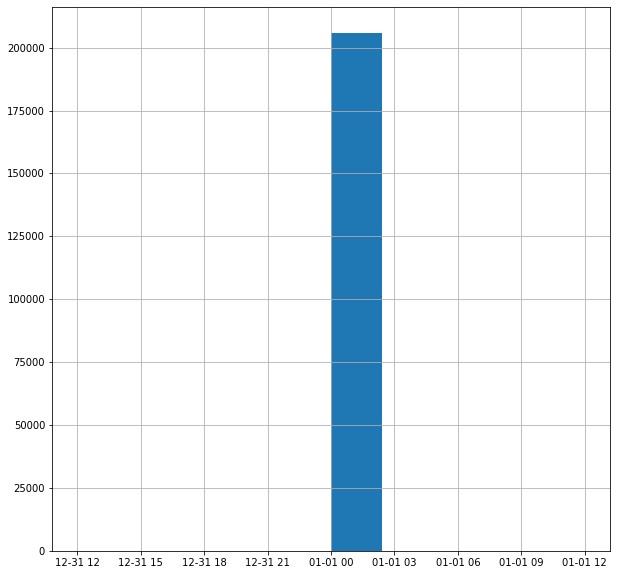

In [190]:


fig = plt.figure(figsize = (10,10))
ax = fig.gca()

df_group_by_time.ReportTime.hist(ax=ax)


In [0]:
# df = df[["FileNameID","Sha1ID","ThreatFamilyID","ThreatNameID","WebFileUrlDomain","WebFileUrlHostname"]]
# df.head(n=6)

Textual features:
FileNameID, WebFuleUrlDomain, WebFileUrlHostname.

***FileNameID:***
This column should be used, because it can indicate couple of things about the file itself.
First, the suffix of the file might imply about the maliciousness of the file, for example, 'exe' files are surely more suspicious, because a malicious code might run while executing those files.
Second, the file name itself can raise the suspicious. Common knowledge from surfing the web indicates that attackers might use well-known software names for their malicious files for example "bsplayer_pro270.1080.exe". (entry number 8 at the dataset)

***WebFileUrlDomain:***
Suspicious domains might lead to rais the probability that the file is malicious, even though attackers sometimes use common well-known domains to upload their files, such as Dropbox, GoogleDrive, MediaFire in order to pass some security checks.

***WebFileUrlHostname***
Sometimes the domain (the network itself) might be non-suspicious, but a machine through this domain (the hostname) can produce a lot of malicious files, for example :
"mediafire.com" and the hostname: "download1507.mediafire.com".
With the cloud storage services today, attackers might hide behind those distributed storage services and the hostname should be considered.

In [192]:
#Filtered data-set

df = df[df.FileNameID.str.isdigit() == False]
df.head(n=30)

,FileNameID,Sha256ID,Md5ID,Sha1ID,IssuerID,SignerID,PublisherID,WebFileIpID,WebFileUrlID,ThreatFamilyID,ThreatNameID,SigSeqID,SignatureNameID,MachineGuidID,RowNumber,PeAttributesString,WebFileUrlDomain,WebFileUrlHostname,Ctph,LsHash,ThreatCategory,ReportTime,SpynetReportGuid,Firewall,Size,Version,Type,SignerHash,IssuerHash,IsValidCertificate,CertInvalidDetails,Checksum,IsRuntimePacked,FileAccess,Screensaver,StartupUserFolder,MarkOfTheWeb,UsnTimestamp,IsInContainer,IsContainer,IsPEFile,IsAutoRunInf,PeTimestamp
5,bsplayer_free.exe,6879724,67197,6545231,9618,43582,34,778924,14124668,2720,5644,37,1291,10479025,8249640,"1,5,21,23,25,30,45,46,49,51,60,73,84,86,89,90,...",deliverynowsend.com,www.deliverynowsend.com,24576:5QvY1H02hJ/X99M3suMBWom0cOGNrOhR35qjrmKy...,ebd5b97a77eeeab77aeed66b97d56d7adea77a7d7db9a5...,NaN,2017-01-01,413e9be0-4214-4855-bc79-0ad424ca156d,True,1274648,0.0.0.0,APP,7c3b2769a9c1f667aec9e680f2b144b32edc4f4a,d00cfdbf46c98a838bc10dc4e097ae0152c461bc,True,NaN,9e22bfbd,1.0,2,NaN,NaN,unknown,NaN,NaN,NaN,True,NaN,6/19/1992 10:22:17 PM
8,bsplayer_pro270.1080.exe,3501401,7273057,9117642,9641,46623,188146,1037662,878,2720,5644,24632,616,1156079,903060,"0,1,2,3,12,18,23,24,31,33,38,45,46,49,69,84,85...",NaN,canonicalizer.ucsuri.tcs,6144:VzWiPlwflgiNLfEihMcEIi/NfmFwmEV1JTS+co8W3...,6f69bd6f57b5e6b569beda7f7765db6955e6966ffefb75...,NaN,2017-01-01,4dd0ff6b-32b2-4d83-ad75-5cd9131ae6a3,True,402278,NaN,NaN,NaN,NaN,NaN,NaN,00000000,1.0,2,NaN,NaN,internet,NaN,True,NaN,True,NaN,6/19/1992 10:22:17 PM
9,bsplayer_pro_sa.rar,9001092,5907338,14365028,9641,46623,188146,592096,19654065,2720,5644,1036641,221,13721883,10794560,NaN,cldmail.ru,cloclo28.cldmail.ru,196608:VQI64eTBoDzoQr/7JMvLlndl8LSjfmnnuitty9E...,aa79abbdafebddb5b9feed9f6f659697d77ea7b7ab7efe...,NaN,2017-01-01,7c920f2a-c11f-4ad0-a03e-f8843c0ed771,True,10968324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,internet,NaN,NaN,NaN,False,NaN,NaN
14,bspsrc_1.3.21.rar,11353075,17000738,99222,9641,46623,188146,916667,22339856,2720,5644,1036641,221,26669863,21111130,NaN,googleusercontent.com,doc-0o-9k-docs.googleusercontent.com,24576:g1LtKn5Tfdg3QYj8CuY07gVbhi2ZcQhCj4TbRppD...,bb56dfa965aeddffdaae596f569d7fd6bbdaa576ddaf75...,NaN,2017-01-01,4c77a930-e5cb-4953-87b7-552a99661710,True,1339738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,internet,NaN,NaN,NaN,False,NaN,NaN
16,bspsrc_1.3.21.rar,11353075,17000738,99222,9641,46623,188146,766653,30813797,2720,5644,1036641,221,12770052,10024740,NaN,therazzerapp.de,therazzerapp.de,24576:g1LtKn5Tfdg3QYj8CuY07gVbhi2ZcQhCj4TbRppD...,bb56dfa965aeddffdaae596f569d7fd6bbdaa576ddaf75...,NaN,2017-01-01,d7ce69d3-2d62-4eb0-8267-783ca785305d,True,1339738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,internet,NaN,NaN,NaN,False,NaN,NaN
17,! !§5DarkShooter §3[10k] §5Pack.rar,14658809,6649767,3042011,9641,46623,188146,516414,4884433,2720,5644,1036378,227,20265042,16035890,NaN,mediafire.com,download1120.mediafire.com,196608:6VymlwXn2iFmGNskLKYIwF5D7LXEqUbBJFQIUx7...,bbfffbbbdbdfa6f9575a679d67ffd6699b9dabb5bd96b6...,NaN,2017-01-01,75d9c215-4c67-4e48-b502-840b84b3208b,True,14148736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,internet,NaN,NaN,NaN,False,NaN,NaN
18,pcmaster_6.2.1.0_setup_u92.exe,16565404,12034874,18249637,9641,46623,186698,166472,11605396,2720,5644,1036325,628,17210263,13673050,"1,5,21,23,25,43,45,46,60,69,73,77,98,106,109,1...",baidu.com,sw.bos.baidu.com,196608:VV8mZL2xozgMLEAeqXlw5Y3dxj149WyLf8reaZX...,7b6b9aeb67575f6977afedee557ffad9ef7a59baf9af6b...,NaN,2017-01-01,638ff86e-835c-42e6-a60e-75d74e9963f1,True,12770048,6.2.1.0,APP,NaN,NaN,NaN,NaN,00c3615a,1.0,2,NaN,NaN,restricted_sites,NaN,NaN,NaN,True,NaN,9/26/2011 1:21:33 PM
22,MW3.1(1.1.1.86)Installer_IS_rev2.exe,10277180,14374549,2078403,9641,46623,101944,898071,17188825,2720,5644,1036485,632,1738307,1380320,"1,3,5,21,23,25,31,37,45,63,69,73,85,94,106,109...",xkeys.com,xkeys.com,393216:MXuadsUu/aMi4Wq5qsuVqg8wCtKr0XV6dQSNEGa...,bbe6a96f5b6fef56f7feb55be76be55eeda6a6696ae665...,NaN,2017-01-01,757311ba-b151-4a8d-

In [193]:
df.shape

(76088, 43)

In [194]:
# df.ReportTime = df.ReportTime.apply(dump_time)

# df.ReportTime = pd.to_datetime(df.ReportTime)

df_group_by_time = df.groupby(df.ReportTime.dt.day)

df_group_by_time.tail(n=6)

,FileNameID,Sha256ID,Md5ID,Sha1ID,IssuerID,SignerID,PublisherID,WebFileIpID,WebFileUrlID,ThreatFamilyID,ThreatNameID,SigSeqID,SignatureNameID,MachineGuidID,RowNumber,PeAttributesString,WebFileUrlDomain,WebFileUrlHostname,Ctph,LsHash,ThreatCategory,ReportTime,SpynetReportGuid,Firewall,Size,Version,Type,SignerHash,IssuerHash,IsValidCertificate,CertInvalidDetails,Checksum,IsRuntimePacked,FileAccess,Screensaver,StartupUserFolder,MarkOfTheWeb,UsnTimestamp,IsInContainer,IsContainer,IsPEFile,IsAutoRunInf,PeTimestamp
205766,MVC-3.0.exe,11628433,3630493,10349208,9641,46623,103737,873527,8139381,2720,5644,24632,616,1902057,1509690,"1,3,5,21,23,37,45,85,94,98,106,109,110,111,112...",osuosl.org,ftp.osuosl.org,384:iWDyq0z2U5v9RvzQckn8IxfZEiagugoL2RHugIpRTR...,d7e6b97f9f59ddea9b59da6feb5a9a79df665a7bafa669...,NaN,2017-01-01,64653e5a-dbb2-4201-9ae4-eb9692ca7d67,True,20480,3.0.0.0,APP,NaN,NaN,NaN,NaN,00007ab2,0.0,2,NaN,NaN,internet,NaN,True,NaN,True,NaN,10/30/2012 9:07:17 PM
205783,"MW2,PC-UnlockAll.rar",6199119,8493487,1922707,9641,46623,188146,516433,4891953,2720,5644,1036641,221,13627459,10725080,NaN,mediafire.com,download1138.mediafire.com,24576:CEl1QnWCPXE9+eCt3FLbzPxysqWd37rSkMubBmDF...,bb66d6aed759b665699dee697a5dba9d5597b6777ed7fa...,NaN,2017-01-01,296b9862-719b-4f4c-9ecb-ce1bff7b4a8e,True,1127190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,internet,NaN,NaN,NaN,False,NaN,NaN
205787,MW2RustZombies_1.01_zm.exe,5408277,7893603,4216411,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,3351130,2607500,"1,3,5,21,23,31,38,43,45,46,49,60,77,106,109,11...",zmupload.com,zmupload.com,768:94wO7XBz+5Qm3W0tYdrQZHV4EWuWEUOg4jjfS3P:+L...,6beb9abd6fbedb6def7ee7775795d65ddfa77ab5afd676...,NaN,2017-01-01,74327f2d-71c8-4fc3-aef6-509c4fff7df1,True,28232,NaN,NaN,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205788,MW2RustZombies_1.01_zm.exe,5408277,7893603,4216411,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,17277466,13721080,"1,3,5,21,23,31,38,43,45,46,49,60,77,106,109,11...",zmupload.com,zmupload.com,768:94wO7XBz+5Qm3W0tYdrQZHV4EWuWEUOg4jjfS3P:+L...,6beb9abd6fbedb6def7ee7775795d65ddfa77ab5afd676...,NaN,2017-01-01,a7d2984d-4104-4852-bfc4-2b33ff899176,True,28232,NaN,NaN,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205789,MW2RustZombies_1.01_zm.exe,5408277,7893603,4216411,9641,46623,188146,1012393,17246062,2720,5644,1036485,632,30043715,23833910,"1,3,5,21,23,31,38,43,45,46,49,60,77,106,109,11...",zmupload.com,zmupload.com,768:94wO7XBz+5Qm3W0tYdrQZHV4EWuWEUOg4jjfS3P:+L...,6beb9abd6fbedb6def7ee7775795d65ddfa77ab5afd676...,NaN,2017-01-01,a77bfeed-e427-45cb-97c3-f9bc2715037e,True,28232,NaN,NaN,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,12/5/2009 10:50:41 PM
205790,MW2_MP_FoV-Changer-v1-2-211-0.zip,1680908,8941078,14699971,9641,46623,188146,979277,14928587,2720,5644,24632,616,4695249,3612120,"1,5,21,23,31,37,45,85,94,97,106,109,110,113,11...",mapmodnews.com,www.mapmodnews.com,1536:gg7SAbkt/THgYhbOSsZiNlEktXk18LFrJy8zR2ktp...,efeef5afff7b657b5b9e6aab9bd666565e755da96f5555...,NaN,2017-01-01,a715ae3a-f611-478f-a8a9-e302c6c04bed,True,83456,1.0.0.0,APP,NaN,NaN,NaN,NaN,00000000,0.0,2,NaN,NaN,internet,NaN,True,NaN,True,NaN,9/9/2015 4:20:21 AM


ReportTime
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: ReportTime, dtype: object

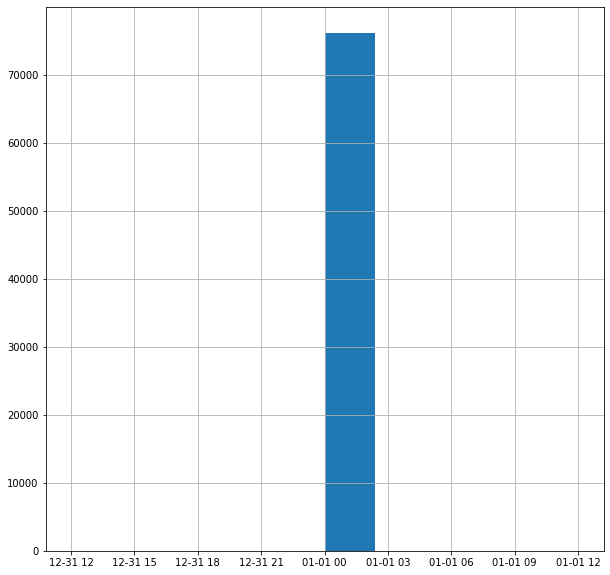

In [195]:
# data.groupby(data.date.dt.year)
# df_group_by_time = df.groupby(df.ReportTime.dt.year)
# df_group_by_time.head(n=6)

# df.ReportTime = df.ReportTime.apply(dump_time)
# df.head(n=3)



fig = plt.figure(figsize = (10,10))
ax = fig.gca()

df_group_by_time.ReportTime.hist(ax=ax)



In [196]:
df.shape

(76088, 43)

In [0]:
def replace_nans(corpus):
  return [w if isinstance(w,str) else '' for w in corpus]


In [198]:
file_names = [x for x in df.FileNameID]
domain_names = replace_nans([x for x in df.WebFileUrlDomain])
hostname_names = replace_nans([x for x in df.WebFileUrlHostname])
len(file_names)
print("Size of file_names : {}, Size of domain_names : {}, Size of hostnames_names: {}".format(len(file_names), len(domain_names), len(hostname_names)))




Size of file_names : 76088, Size of domain_names : 76088, Size of hostnames_names: 76088


In [0]:
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#file_names is a list of all text entries in the column at the DataFrame.
#Returns - a dense matrix that each row is a n-gram representation of the entries.
def extract_ngrams_as_one_hot(corpus, ngram_size=3,pipeline=None):
  vectorizer = CountVectorizer(ngram_range=(ngram_size, ngram_size), 
                              analyzer='char',preprocessor=pipeline)

  X = vectorizer.fit_transform(corpus)
  
  print("------")
  v = vectorizer.transform([corpus[0]]).toarray()
  print(vectorizer.get_feature_names())
  # print(v)
  return X


def extract_ngrams_as_tf_idf(corpus, ngram_size=3,pipeline=None):
  vectorizer = TfidfVectorizer(ngram_range=(ngram_size, ngram_size), 
                              analyzer='char',preprocessor=pipeline)

  X = vectorizer.fit_transform(corpus)
  
  print("------")
  v = vectorizer.transform([corpus[0]]).toarray()
  print(vectorizer.get_feature_names())
  # print(v)
  return X


In [200]:
names = ['OMER', 'nit']
print(extract_ngrams_as_tf_idf(names))

print("-----------------")

print(extract_ngrams_as_one_hot(names).toarray())

------
['mer', 'nit', 'ome']
  (0, 0)	0.7071067811865476
  (0, 2)	0.7071067811865476
  (1, 1)	1.0
-----------------
------
['mer', 'nit', 'ome']
[[1 0 1]
 [0 1 0]]


WorkFlow:
The workflow we chose is to aggregate features for each entry in the data set
by iterating through the columns and concatanating text and global features for each entry with the goal of transform it to a wide input vector.
For example, given the corpus ['OMER', 'nit'] considered as a column. 
We exctract 3-grams from it by examine 2 possible representations for each entry within it which will be tested later in the training part:
1. Tf-idf representation of the corpus
2. One-hot representation of the corpus.

# **Text analysis features:**

First for each text feature chosen, we should each entry in the dataset through a pipeline of normalizations before analysis:
1. Removing digits - some files might contain their versions in their names.
2. Casing - for widely conventions we shall use lower-case.
3. Stop words - replacing each stopword with sepcial char in order to increase the reliability of td-idf method.

In [0]:
#Taken from https://gist.github.com/sebleier/554280 -> NLTK english stop words
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your",
              "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", 
              "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what",
              "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were",
              "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a",
              "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by",
              "for", "with", "about", "against", "between", "into", "through", "during", "before", "after",
              "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again",
              "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both",
              "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same",
              "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [0]:
REMOVE_PUNTS = True
LOWER_CASE = True
REMOVE_DIGITS = True
STOP_WORDS = True
REMOVE_SPACES = True

In [203]:
name = 'bsv3.6.0.550.CN.2899892505.exe'
name2 = 'bsv3.6.0.550.CN.exe	'

#All functions returns string.

#Remove any punctuations
def remove_puncts(corpus):
  return "".join([c for c in corpus if c.isalpha() or c.isdigit()])

#Replace the digits with char 
def replace_digits(corpus, char=''):
  return "".join([char if c.isdigit() else c for c in corpus ])

#Return lower-case string
def lower_case(corpus):
  return corpus.lower()


#Replace each ngram that equals to one of the stop_ngrams with word_to_replace.
def replace_n_grams_stop_ngrams(corpus, stop_ngrams,n=3, word_to_replace=''):
  grams = []
  str_to_ret = ''
  i=n
  while i<=len(corpus):
    if i>=n:
      grama = corpus[i-n:i]
      if grama in stop_ngrams:
        str_to_ret = str_to_ret + word_to_replace
        i = i + 3
      else:
        str_to_ret = str_to_ret + corpus[i-n]    
        i = i + 1
  tail = corpus[i-n:]
  str_to_ret = str_to_ret + tail
  return str_to_ret


print(remove_puncts(name))
print(remove_puncts(name2))


print(replace_n_grams_stop_ngrams("whathatgab3",stop_ngrams=['hat'],n=3))

bsv360550CN2899892505exe
bsv360550CNexe
wgab3


In [0]:
def remove_suffix_of_url(word):
  parts = word.split(".")  
  return ".".join(parts[:-1])

def remove_prefix_of_url(word):
  parts = word.split(".") 
  return ".".join(parts[1:])

In [205]:
print(remove_suffix_of_url("www.google.com"))
print(remove_prefix_of_url("www.google.com"))

www.google
google.com


**Pipeline for filename explanation:**
- remove_puncts - No meaning for punctuation in the filname
- replace_digits - Usually the numbers in the filename indicates the version of a file which has no additional info if we inspect the meaning of the filename.
- lower_case -Lets take a look on an example : BSPLAYER bsplayer BSplayer ---> BSP, bsp , BSp, we would like to treat them as the same n-gram.

**Pipeline for domain explanation:**
- remove_puncts - No meaning for punctuation in the domain
- removing_suffix_of_url - No additional info will be derived from the suffix of the domain (either com, ru, org, etc...)

**Pipeline for hostname explanation:**
- remove_puncts - No meaning for punctuation in the domain
- remove_suffix_of_url - same as domain.
- replace_n_grams_stop_ngrams - replace each of the common stop-words ngrams such as 'www'.


In [0]:
# Explanation above.
def pipeline_for_filename(word): 
  word = remove_puncts(word) 
  word = replace_digits(word)
  word = lower_case(word) 
  return word

def pipeline_for_domain(word):
  word = remove_suffix_of_url(word)
  word = remove_puncts(word)
  return word
  

def pipeline_for_hostname(word):
  stop_words = ['www'] #Consider add more common prefix
  word = remove_suffix_of_url(word)
  word = replace_n_grams_stop_ngrams(word, stop_words)
  word = remove_puncts(word)
  return word


In [207]:
print("before")
print(domain_names[:5])
print([remove_suffix_of_url(w) for w in domain_names][:5])

before
['deliverynowsend.com', '', 'cldmail.ru', 'googleusercontent.com', 'therazzerapp.de']
['deliverynowsend', '', 'cldmail', 'googleusercontent', 'therazzerapp']


In [208]:
def print_example(input):
  chopped = input[:5]
  print("Before:")
  print(chopped)
  print("After:")
  print([pipeline_for_filename(w) for w in chopped])

print_example(file_names)
print_example(domain_names)
print_example(hostname_names)

Before:
['bsplayer_free.exe', 'bsplayer_pro270.1080.exe', 'bsplayer_pro_sa.rar', 'bspsrc_1.3.21.rar', 'bspsrc_1.3.21.rar']
After:
['bsplayerfreeexe', 'bsplayerproexe', 'bsplayerprosarar', 'bspsrcrar', 'bspsrcrar']
Before:
['deliverynowsend.com', '', 'cldmail.ru', 'googleusercontent.com', 'therazzerapp.de']
After:
['deliverynowsendcom', '', 'cldmailru', 'googleusercontentcom', 'therazzerappde']
Before:
['www.deliverynowsend.com', 'canonicalizer.ucsuri.tcs', 'cloclo28.cldmail.ru', 'doc-0o-9k-docs.googleusercontent.com', 'therazzerapp.de']
After:
['wwwdeliverynowsendcom', 'canonicalizerucsuritcs', 'cloclocldmailru', 'docokdocsgoogleusercontentcom', 'therazzerappde']


In [209]:
from scipy.sparse import coo_matrix, hstack

def agg(func,corpus,extractor):
  X = extractor(corpus,pipeline=func)
  return X

one_hot_mat_for_file_name = agg(pipeline_for_filename,file_names,extract_ngrams_as_one_hot)
one_hot_mat_for_domain = agg(pipeline_for_domain,domain_names,extract_ngrams_as_one_hot)
one_hot_mat_for_hostname = agg(pipeline_for_hostname,hostname_names,extract_ngrams_as_one_hot)

print("Shapes:")
print("one_hot_mat_for_file_name: {}".format(one_hot_mat_for_file_name.shape))
print("one_hot_mat_for_domain: {}".format(one_hot_mat_for_domain.shape))
print("one_hot_mat_for_hostname: {}".format(one_hot_mat_for_hostname.shape))

tfidf_mat_for_file_name = agg(pipeline_for_filename,file_names,extract_ngrams_as_tf_idf)
tfidf_mat_for_domain = agg(pipeline_for_domain,domain_names,extract_ngrams_as_tf_idf)
tfidf_mat_for_hostname = agg(pipeline_for_hostname,hostname_names,extract_ngrams_as_tf_idf)

print("--------")

print("Shapes:")
print("tfidf_mat_for_file_name: {}".format(tfidf_mat_for_file_name.shape))
print("tfidf_mat_for_domain: {}".format(tfidf_mat_for_domain.shape))
print("tfidf_mat_for_hostname: {}".format(tfidf_mat_for_hostname.shape))

one_hot_mat_text_features = hstack([one_hot_mat_for_file_name,one_hot_mat_for_domain,one_hot_mat_for_hostname])

tfidf_mat_text_features = hstack([tfidf_mat_for_file_name,tfidf_mat_for_domain,tfidf_mat_for_hostname])

print("--------")

print("Total shapes:")
print("one_hot_mat_text_features: {}".format(one_hot_mat_text_features.shape))
print("tfidf_mat_text_features: {}".format(tfidf_mat_text_features.shape))


------
['aaa', 'aab', 'aac', 'aad', 'aae', 'aag', 'aah', 'aai', 'aal', 'aan', 'aao', 'aap', 'aar', 'aas', 'aat', 'aau', 'aav', 'aaw', 'aax', 'aay', 'aaz', 'aba', 'abb', 'abc', 'abd', 'abe', 'abf', 'abg', 'abh', 'abi', 'abl', 'abm', 'abn', 'abo', 'abp', 'abr', 'abs', 'abt', 'abu', 'abv', 'abw', 'abx', 'aby', 'abz', 'aca', 'acb', 'acc', 'acd', 'ace', 'acf', 'acg', 'ach', 'aci', 'acj', 'ack', 'acl', 'acm', 'acn', 'aco', 'acp', 'acr', 'acs', 'act', 'acu', 'acv', 'acw', 'acx', 'acy', 'acz', 'ada', 'adb', 'adc', 'add', 'ade', 'adf', 'adg', 'adh', 'adi', 'adj', 'adk', 'adl', 'adm', 'adn', 'ado', 'adp', 'adr', 'ads', 'adt', 'adu', 'adv', 'adw', 'adx', 'ady', 'adz', 'ad快', 'ad注', 'aea', 'aeb', 'aec', 'aed', 'aef', 'aeg', 'aeh', 'aek', 'ael', 'aem', 'aen', 'aeo', 'aep', 'aer', 'aes', 'aeu', 'aev', 'aex', 'aey', 'aez', 'afa', 'afb', 'afe', 'aff', 'afg', 'afh', 'afi', 'afk', 'afl', 'afm', 'afo', 'afp', 'afr', 'afs', 'aft', 'afu', 'afw', 'afy', 'aga', 'agb', 'agc', 'agd', 'age', 'agg', 'agh', 'agi'

In [0]:
##TODO:
#0. Analysis of the data
#1. Global feature extraction
#2. Time-split
#3. Aggregating the data features
#4. tagging
#5. train
#6. cross-validation

Aggregating the data:
Some files might appear on few entries in the dataset, using the sha1ID,
we can recongize them along the dataset and extract a list of names which this file was known for.

In [0]:
def collect_names(sha1):
  pass

def collect_hostnames(sha1):
  pass

def collect_domains(sha1):
  pass

# **Textual features analysis:**

As we know, the sha1 is hash function working on the content of the file,
so here is the histogram in order to see which files are the most frequent (maybe with different names with the same sha1) in the dataset reports.

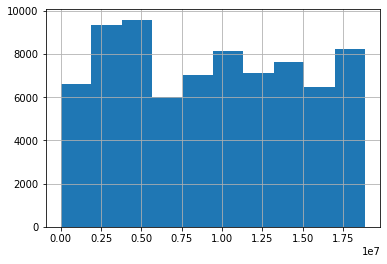

In [212]:
df["Sha1ID"].hist()

Analyzing the threat family of the reports, we can see that most of the reports include the same threat name or threat family, because of the anonymization we can tell which one.

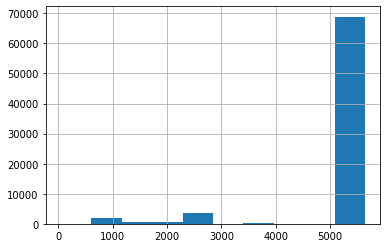

In [213]:
df["ThreatNameID"].hist() 

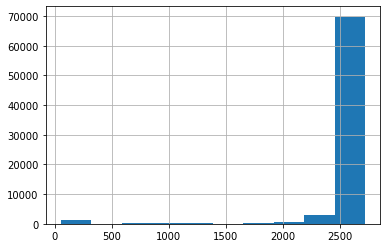

In [214]:
df["ThreatFamilyID"].hist()


1)This is sparta
2)This is garta
3)This marta

D1 - Cow , The
D2 - Dog, is, no
TF - Term Frequency.  -----> 1000
IDF - Inverse Document Frequency ---> 3 --> inverse 

Vocab - Document


cow ---> 0-1 ----> This - 0.01 , Cow - 0.99

Thi, his, isi, sis, iss, ssp, spa, part, art, rta

bsplayer_free.exe
bsplayer_pro270.1080.exe

BoW -----> Tokenize ----> "This is sparta" -> This, is, Sparta. 200,000 -> [...]


100 -> [.....] onehot vector ---> 100 [0, 1,0 ,1...] 

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [0]:
# Train : the dataframe that is used to determine which files are clean and which are malicious
#is the dataframe itself of the train.
#Test : the dataframe that is used to determine which files are clean and which malicious
#is the the whole dataset.

sha1_for_train = train.Sha1ID.value_counts()
sha1_for_test = df.Sha1ID.value_counts()

d_sha1_for_train = dict(sha1_for_train)
d_sha1_for_test = dict(sha1_for_test)


In [237]:
train.head(2)

,FileNameID,Sha256ID,Md5ID,Sha1ID,IssuerID,SignerID,PublisherID,WebFileIpID,WebFileUrlID,ThreatFamilyID,ThreatNameID,SigSeqID,SignatureNameID,MachineGuidID,RowNumber,PeAttributesString,WebFileUrlDomain,WebFileUrlHostname,Ctph,LsHash,ThreatCategory,ReportTime,SpynetReportGuid,Firewall,Size,Version,Type,SignerHash,IssuerHash,IsValidCertificate,CertInvalidDetails,Checksum,IsRuntimePacked,FileAccess,Screensaver,StartupUserFolder,MarkOfTheWeb,UsnTimestamp,IsInContainer,IsContainer,IsPEFile,IsAutoRunInf,PeTimestamp
31772,flux-setup.exe,2845593,17442637,12840024,80,7040,188146,577757,25074660,2720,5644,1036325,628,27859808,22091530,"1,3,5,21,23,25,43,45,46,60,63,77,89,98,106,109...",justgetflux.com,justgetflux.com,12288:sy/4EdJu9QBrRyxb2RU9x+8xy04N69SjuqwAhk/2...,77efd5bf9fa99ebf6f69e9af7b5a95595e6765ee7ee659...,NaN,2017-01-01,e8363cbd-55da-47d7-bdb1-01ea828ee6bf,True,496896,NaN,NaN,36e504701938fea480db816490d6eae042eb7907,b69e752bbe88b4458200a7c0f4f5b3cce6f35b47,True,NaN,0007afda,1.0,2,NaN,NaN,internet,NaN,NaN,NaN,True,NaN,4/2/2016 3:20:05 AM
47472,Prism.rar,864280,5314779,15147246,9641,46623,188146,516459,5038616,2720,5644,1280,1319,29939200,23757120,NaN,mediafire.com,download1413.mediafire.com,384:EJXJRGmQQOECCMaRsIoL2+DOEHy1+tbK7Zv5Ye45Nd...,7ef659e75595a6bab75addefb69e6dae975d5b79aedd7a...,NaN,2017-01-01,884ee015-04ef-446e-b329-bcf3d2c269ba,True,22020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,unknown,NaN,True,NaN,False,NaN,NaN


In [0]:
#Lets define : Sha1Counter(dict of sha1 - how many times it appeared) in a given dataframe.
#Input : Given a group of examples known as the data frame.
#Output: Sha1Counter for cleans , Sha1Counter for malicious, list of labels for a given data frame.
def split_to_clean_and_mal(sha1_dict,df,threshold=100):
  sha1_clean = []
  sha1_mal = []
  for k,v in sha1_dict.items():
    if v > threshold:
      sha1_clean.append(k)
    else:
      sha1_mal.append(k)

  Y = []
  df_clean = pd.DataFrame()
  df_malicious = pd.DataFrame()
  for i,(ind,row) in enumerate(df.iterrows()):
    sha1 = df.Sha1ID[ind]
    if sha1_dict[sha1] > threshold:
      Y.append(0)
    elif sha1_dict[sha1] <= threshold:
      Y.append(1)

  return df[df.Sha1ID.isin(sha1_clean)],df[df.Sha1ID.isin(sha1_mal)],Y

In [240]:
train_df_clean,train_df_mal,Y_train = split_to_clean_and_mal(d_sha1_for_train,train)

test_df_clean,test_df_mal,Y_test = split_to_clean_and_mal(d_sha1_for_test,test)

train_counted_clean_f = train_df_clean.shape[0]
train_counted_malicious_f = train_df_mal.shape[0]
test_counted_clean_f = test_df_clean.shape[0]
test_counted_malicious_f = test_df_mal.shape[0]


print("-----------------Train---------------------")

print("Based on train only : Number of clean files: {} , Number of malicious files: {}".format(train_counted_clean_f,train_counted_malicious_f))

print("-----------------Test---------------------")

print("Based of train+test : Number of clean files: {} , Number of malicious files: {}".format(test_counted_clean_f,test_counted_malicious_f))

print("-------------------------------------------")

print("Counted labeled examples in train : {}".format(len(Y_train)))
print("Counted labeled examples in test : {}".format(len(Y_test)))


what
-----------------Train---------------------
Based on train only : Number of clean files: 10499 , Number of malicious files: 50371
-----------------Test---------------------
Based of train+test : Number of clean files: 3069 , Number of malicious files: 12149
-------------------------------------------
Counted labeled examples in train : 60870
Counted labeled examples in test : 15218


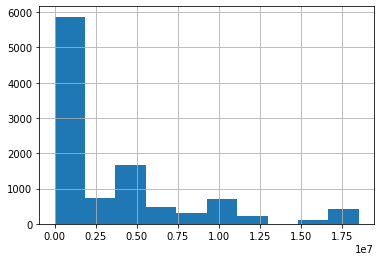

In [241]:
train_df_clean.Size.hist()

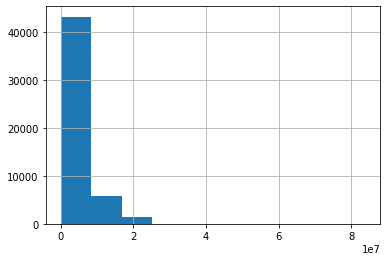

In [242]:
train_df_mal.Size.hist()

In [0]:
sha1_for_test.hist()
